In [ ]:
!nvidia-smi



Thu Oct  9 17:40:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import triton
print("Triton version:", triton.__version__)



Triton version: 3.4.0


In [ ]:
import torch, triton, triton.language as tl

@triton.jit
def relu_kernel(x_ptr, y_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid  = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements
    x    = tl.load(x_ptr + offs, mask=mask, other=0.0)
    y    = tl.maximum(x, 0.0)
    tl.store(y_ptr + offs, y, mask=mask)

def relu_triton(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda and x.is_contiguous()
    y = torch.empty_like(x)
    n = x.numel()
    BLOCK = 1024
    grid = lambda meta: (triton.cdiv(n, meta['BLOCK_SIZE']),)
    relu_kernel[grid](x, y, n, BLOCK_SIZE=BLOCK)
    return y


,shape,torch_ms,triton_ms,correct
0,"(1, 1024)",0.035452,0.039673,True
1,"(32, 1024)",0.008879,0.035820,True
2,"(64, 4096)",0.008694,0.035205,True
3,"(128, 4096)",0.010921,0.037867,True
4,"(32, 64, 224, 224)",3.458539,3.566351,True


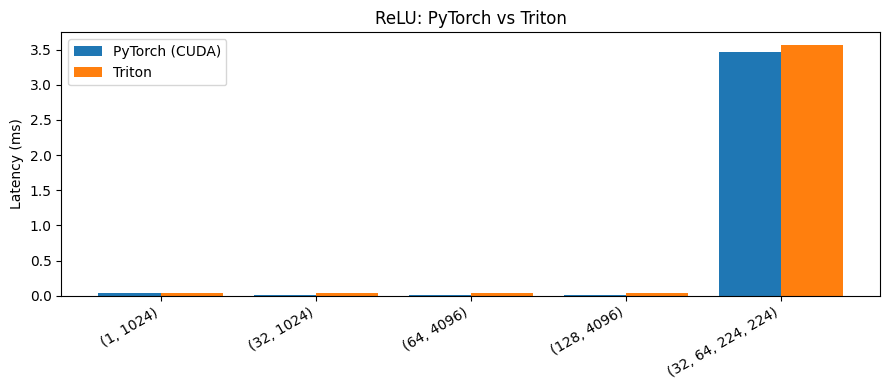

In [ ]:
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt

def time_op(fn, x, iters=100):
    for _ in range(10): fn(x)          # warmup
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(iters): fn(x)
    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end)/iters  # ms

shapes = [(1,1024),(32,1024),(64,4096),(128,4096),(32,64,224,224)]
rows = []
for shape in shapes:
    x = torch.randn(*shape, device="cuda", dtype=torch.float32).contiguous()
    ms_torch = time_op(lambda t: torch.nn.functional.relu(t), x)
    y_torch  = torch.nn.functional.relu(x)
    ms_trit  = time_op(lambda t: relu_triton(t.view(-1)).view_as(t), x)  # run on flat then reshape
    y_trit   = relu_triton(x.view(-1)).view_as(x)
    ok = torch.allclose(y_torch, y_trit)
    rows.append((str(shape), ms_torch, ms_trit, bool(ok)))

df = pd.DataFrame(rows, columns=["shape","torch_ms","triton_ms","correct"])
display(df)

# chart
x = np.arange(len(df)); w=0.4
plt.figure(figsize=(9,4))
plt.bar(x-w/2, df["torch_ms"], width=w, label="PyTorch (CUDA)")
plt.bar(x+w/2, df["triton_ms"], width=w, label="Triton")
plt.xticks(x, df["shape"], rotation=30, ha="right")
plt.ylabel("Latency (ms)")
plt.title("ReLU: PyTorch vs Triton")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
import triton, triton.language as tl, torch

@triton.jit
def sigmoid_kernel(x_ptr, y_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid  = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements
    x    = tl.load(x_ptr + offs, mask=mask, other=0.0)
    # sigmoid(x) = 1 / (1 + exp(-x))
    y    = 1.0 / (1.0 + tl.exp(-x))
    tl.store(y_ptr + offs, y, mask=mask)

def sigmoid_triton(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda and x.is_contiguous()
    y = torch.empty_like(x)
    n = x.numel(); BLOCK=1024
    grid = lambda meta: (triton.cdiv(n, meta['BLOCK_SIZE']),)
    sigmoid_kernel[grid](x, y, n, BLOCK_SIZE=BLOCK)
    return y


In [ ]:
# quick correctness + timing vs PyTorch
shapes = [(1,1024),(32,1024),(64,4096)]
for shape in shapes:
    x = torch.randn(*shape, device="cuda", dtype=torch.float32).contiguous()
    y_torch = torch.sigmoid(x)
    y_trit  = sigmoid_triton(x.view(-1)).view_as(x)
    print(shape, "correct:", bool(torch.allclose(y_torch, y_trit, atol=1e-6)))
    print("torch ms:", time_op(lambda t: torch.sigmoid(t), x))
    print("triton ms:", time_op(lambda t: sigmoid_triton(t.view(-1)).view_as(t), x))


(1, 1024) correct: True
torch ms: 0.010871360301971436
triton ms: 0.037587840557098386
(32, 1024) correct: True
torch ms: 0.00842848002910614
triton ms: 0.03632352113723755
(64, 4096) correct: True
torch ms: 0.008414080142974853
triton ms: 0.0356934404373169


In [ ]:
import math, torch, triton, triton.language as tl

@triton.jit
def softmax_rowwise_kernel(x_ptr, y_ptr, n_rows, n_cols,
                           stride_xr, stride_xc, stride_yr, stride_yc,
                           BLOCK_SIZE: tl.constexpr):
    row_id = tl.program_id(axis=0)               # one program per row
    cols = tl.arange(0, BLOCK_SIZE)
    row_ptr_x = x_ptr + row_id * stride_xr
    row_ptr_y = y_ptr + row_id * stride_yr
    mask = cols < n_cols

    # load row chunked; compute max for numerical stability
    x = tl.load(row_ptr_x + cols * stride_xc, mask=mask, other=-float('inf'))
    x_max = tl.max(x, axis=0)
    x = x - x_max
    expx = tl.exp(x)
    denom = tl.sum(expx, axis=0)
    out = expx / denom
    tl.store(row_ptr_y + cols * stride_yc, out, mask=mask)

def softmax_triton_lastdim(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda and x.is_contiguous()
    # collapse to [rows, cols] with last dim as cols
    cols = x.shape[-1]
    rows = x.numel() // cols
    x2 = x.view(rows, cols)
    y2 = torch.empty_like(x2)
    BLOCK = 1024  # works for cols<=1024; for larger dims we’ll tile/split
    assert cols <= BLOCK, "For cols>1024 we’ll add a tiled version—start with <=1024."
    grid = (rows,)
    softmax_rowwise_kernel[grid](
        x2, y2, rows, cols,
        x2.stride(0), x2.stride(1), y2.stride(0), y2.stride(1),
        BLOCK_SIZE=BLOCK
    )
    return y2.view_as(x)


In [ ]:
for shape in [(16, 512), (32, 1024)]:
    x = torch.randn(*shape, device="cuda", dtype=torch.float32).contiguous()
    y_t = torch.softmax(x, dim=-1)
    y_tr = softmax_triton_lastdim(x)
    print(shape, "correct:", bool(torch.allclose(y_t, y_tr, atol=1e-5)))


(16, 512) correct: True
(32, 1024) correct: True


In [ ]:
import torch, triton, triton.language as tl
from triton.runtime.autotuner import Config

@triton.autotune(
    configs=[
        Config({'BLOCK_SIZE':512},  num_warps=4),
        Config({'BLOCK_SIZE':1024}, num_warps=4),
        Config({'BLOCK_SIZE':2048}, num_warps=8),
    ],
    key=['n_cols'],
)
@triton.jit
def layernorm_fwd_kernel(x_ptr, y_ptr, gamma_ptr, beta_ptr,
                         n_rows, n_cols,
                         stride_xr, stride_xc, stride_yr, stride_yc,
                         eps: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols

    x_row = x_ptr + row * stride_xr + cols * stride_xc
    y_row = y_ptr + row * stride_yr + cols * stride_yc

    x = tl.load(x_row, mask=mask, other=0.0)

    mean = tl.sum(x, axis=0) / n_cols
    x_centered = x - mean
    var = tl.sum(x_centered * x_centered, axis=0) / n_cols
    inv_std = 1.0 / tl.sqrt(var + eps)

    gamma = tl.load(gamma_ptr + cols, mask=mask, other=1.0)
    beta  = tl.load(beta_ptr  + cols, mask=mask, other=0.0)

    y = (x_centered * inv_std) * gamma + beta
    tl.store(y_row, y, mask=mask)

def layernorm_triton(x: torch.Tensor, gamma: torch.Tensor, beta: torch.Tensor, eps=1e-5):
    assert x.is_cuda and x.is_contiguous()
    assert gamma.is_cuda and beta.is_cuda
    cols = x.shape[-1]
    rows = x.numel() // cols
    x2 = x.view(rows, cols)
    y2 = torch.empty_like(x2)
    grid = (rows,)
    layernorm_fwd_kernel[grid](
        x2, y2, gamma, beta,
        rows, cols,
        x2.stride(0), x2.stride(1), y2.stride(0), y2.stride(1),
        eps=eps, n_cols=cols
    )
    return y2.view_as(x)

In [ ]:
def layernorm_triton(x: torch.Tensor, gamma: torch.Tensor, beta: torch.Tensor, eps=1e-5):
    assert x.is_cuda and x.is_contiguous()
    assert gamma.is_cuda and beta.is_cuda
    cols = x.shape[-1]
    rows = x.numel() // cols
    x2 = x.view(rows, cols)
    y2 = torch.empty_like(x2)
    grid = (rows,)

    # NOTE: pass n_cols ONLY positionally; do NOT also pass n_cols=cols
    layernorm_fwd_kernel[grid](
        x2, y2, gamma, beta,
        rows, cols,
        x2.stride(0), x2.stride(1),
        y2.stride(0), y2.stride(1),
        eps=eps,  # only eps as kwarg; BLOCK_SIZE is chosen by autotune
    )
    return y2.view_as(x)


In [ ]:
def check_ln(shape=(32,1024), eps=1e-5):
    x = torch.randn(*shape, device='cuda', dtype=torch.float32).contiguous()
    gamma = torch.randn(shape[-1], device='cuda', dtype=torch.float32)
    beta  = torch.randn(shape[-1], device='cuda', dtype=torch.float32)
    y_torch  = torch.nn.functional.layer_norm(x, (shape[-1],), gamma, beta, eps)
    y_triton = layernorm_triton(x, gamma, beta, eps)
    print(shape, "correct:", bool(torch.allclose(y_torch, y_triton, atol=1e-5)))

for sh in [(32,512),(32,1024),(64,2048),(64,4096)]:
    check_ln(sh)


(32, 512) correct: True
(32, 1024) correct: False
(64, 2048) correct: False
(64, 4096) correct: False


In [ ]:
import torch, triton, triton.language as tl

@triton.jit
def layernorm_fwd_kernel(x_ptr, y_ptr, gamma_ptr, beta_ptr,
                         n_rows, n_cols,
                         stride_xr, stride_xc, stride_yr, stride_yc,
                         eps: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    row  = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols

    x_row = x_ptr + row * stride_xr + cols * stride_xc
    y_row = y_ptr + row * stride_yr + cols * stride_yc

    # load as fp32 for stable sums
    x = tl.load(x_row, mask=mask, other=0.0).to(tl.float32)

    # mean & variance with fp32 accumulators
    m   = tl.sum(x, axis=0) / n_cols
    xc  = x - m
    v   = tl.sum(xc * xc, axis=0) / n_cols
    inv = tl.rsqrt(v + eps)   # slightly different rounding path than 1/sqrt

    gamma = tl.load(gamma_ptr + cols, mask=mask, other=1.0).to(tl.float32)
    beta  = tl.load(beta_ptr  + cols, mask=mask, other=0.0).to(tl.float32)

    y = (xc * inv) * gamma + beta
    tl.store(y_row, y, mask=mask)

def layernorm_triton(x: torch.Tensor, gamma: torch.Tensor, beta: torch.Tensor, eps=1e-5):
    assert x.is_cuda and x.is_contiguous()
    assert gamma.is_cuda and gamma.is_contiguous()
    assert beta.is_cuda and beta.is_contiguous()
    cols = x.shape[-1]
    rows = x.numel() // cols

    x2 = x.view(rows, cols).contiguous()
    y2 = torch.empty_like(x2)

    # make BLOCK_SIZE a power-of-two >= cols (cap 4096 for T4)
    BLOCK = 1 << (cols - 1).bit_length()
    BLOCK = min(BLOCK, 4096)

    grid = (rows,)
    layernorm_fwd_kernel[grid](
        x2, y2, gamma, beta,
        rows, cols,
        x2.stride(0), x2.stride(1),
        y2.stride(0), y2.stride(1),
        eps=eps, BLOCK_SIZE=BLOCK
    )
    return y2.view_as(x)



In [ ]:
def ln_err(shape, eps=1e-5):
    x = torch.randn(*shape, device='cuda', dtype=torch.float32).contiguous()
    gamma = torch.randn(shape[-1], device='cuda', dtype=torch.float32).contiguous()
    beta  = torch.randn(shape[-1], device='cuda', dtype=torch.float32).contiguous()
    yt = torch.nn.functional.layer_norm(x, (shape[-1],), gamma, beta, eps)
    yk = layernorm_triton(x, gamma, beta, eps)
    max_abs = (yt - yk).abs().max().item()
    rel = ( (yt - yk).abs() / (yt.abs() + 1e-12) ).max().item()
    print(shape, "max_abs_err:", max_abs, "max_rel_err:", rel)
    return max_abs, rel

for sh in [(32,512),(32,1024),(64,2048),(64,4096)]:
    ln_err(sh)


(32, 512) max_abs_err: 9.5367431640625e-07 max_rel_err: 0.00011011501919711009
(32, 1024) max_abs_err: 9.5367431640625e-07 max_rel_err: 0.001707264338620007
(64, 2048) max_abs_err: 9.5367431640625e-07 max_rel_err: 0.0006299600354395807
(64, 4096) max_abs_err: 1.430511474609375e-06 max_rel_err: 0.001766033936291933


In [ ]:
import triton, triton.language as tl
import torch
from triton.runtime.autotuner import Config

@triton.autotune(
    configs=[
        Config({'BLOCK_SIZE': 256},  num_warps=4),
        Config({'BLOCK_SIZE': 512},  num_warps=4),
        Config({'BLOCK_SIZE': 1024}, num_warps=8),
    ],
    key=['n_elements'],
)
@triton.jit
def affine_relu_kernel(x_ptr, a_ptr, b_ptr, y_ptr,
                       n_elements,
                       BLOCK_SIZE: tl.constexpr):
    pid  = tl.program_id(0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements

    x = tl.load(x_ptr + offs, mask=mask, other=0.0)
    a = tl.load(a_ptr + offs, mask=mask, other=1.0)
    b = tl.load(b_ptr + offs, mask=mask, other=0.0)

    y = x * a + b
    y = tl.maximum(y, 0.0)  # ReLU
    tl.store(y_ptr + offs, y, mask=mask)

def affine_relu_triton(x: torch.Tensor, a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    # expects contiguous CUDA tensors with identical shape
    assert x.is_cuda and a.is_cuda and b.is_cuda
    x = x.contiguous(); a = a.contiguous(); b = b.contiguous()
    y = torch.empty_like(x)
    n = x.numel()
    grid = lambda meta: (triton.cdiv(n, meta['BLOCK_SIZE']),)
    affine_relu_kernel[grid](x, a, b, y, n_elements=n)
    return y



,128,256,512,768,1024
1,0.045384,0.045018,0.044687,0.046408,0.042738
8,0.047036,0.045558,0.044786,0.044230,0.048288
16,0.042516,0.042921,0.043143,0.046192,0.043378
32,0.042640,0.049925,0.044692,0.043237,0.043008
64,0.042815,0.042846,0.043224,0.043437,0.043117


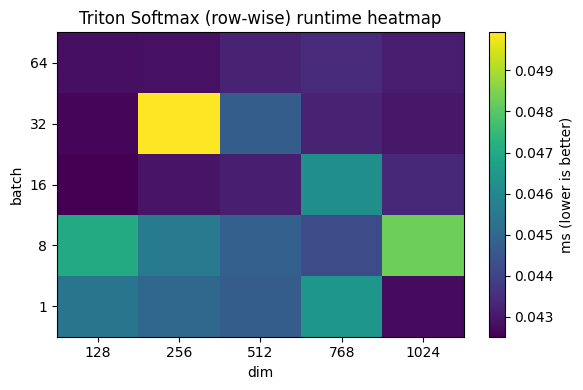

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
batches = [1, 8, 16, 32, 64]
dims    = [128, 256, 512, 768, 1024]   # keep ≤1024 for this simple kernel

def bench_softmax_row(batch, dim, iters=50):
    x = torch.randn(batch, dim, device="cuda", dtype=torch.float32).contiguous()
    # warmup
    for _ in range(10): softmax_triton_lastdim(x)
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(iters): softmax_triton_lastdim(x)
    end.record(); torch.cuda.synchronize()
    return start.elapsed_time(end)/iters  # ms

mat = np.zeros((len(batches), len(dims)), dtype=np.float32)
for i,b in enumerate(batches):
    for j,d in enumerate(dims):
        mat[i,j] = bench_softmax_row(b,d)

df_hm = pd.DataFrame(mat, index=batches, columns=dims)
display(df_hm)

plt.figure(figsize=(6,4))
plt.imshow(mat, aspect='auto', origin='lower')
plt.colorbar(label="ms (lower is better)")
plt.yticks(range(len(batches)), batches); plt.xticks(range(len(dims)), dims, rotation=0)
plt.xlabel("dim"); plt.ylabel("batch")
plt.title("Triton Softmax (row-wise) runtime heatmap")
plt.tight_layout(); plt.show()


In [ ]:
import plotly.express as px
from IPython.display import Image

# Create or assign a figure (replace this with your actual PCA plot)
figPCA = px.scatter(x=[1, 2, 3], y=[4, 5, 6], title="Example PCA Plot")

# Now convert to image
img_bytes = figPCA.to_image(format="png", width=800, height=800, scale=1)

# Display it
Image(img_bytes)


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
import plotly
import plotly.io as pio
print("plotly:", plotly.__version__)
print("kaleido available:", "kaleido" in (pio.kaleido.scope.transformers if hasattr(pio, "kaleido") else {}))


In [ ]:
pip install -U kaleido


In [ ]:
!pip uninstall -y kaleido
!pip install --no-cache-dir kaleido==0.2.1


In [ ]:
import plotly, kaleido, plotly.io as pio
print("plotly:", plotly.__version__)
print("kaleido:", __import__("importlib.metadata").metadata.version("kaleido"))
print("pio.kaleido.scope is None:", pio.kaleido.scope is None)  # should be False once you call to_image()


In [ ]:
import plotly.express as px

figPCA = px.scatter(
    x=[1, 2, 3],
    y=[4, 5, 6],
    title="Example PCA Plot"
)


In [ ]:
from IPython.display import Image

img_bytes = figPCA.to_image(format="png", width=800, height=800, scale=1)
Image(img_bytes)
